In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower
import models

In [12]:
redshifts = [4, 3, 2, 1, 0]
"""Totally wrong! Only the z=0 case is a valid example of evaluating all cosmologies at the same z!
Otherwise, you need to use the z(?) column to figure out which redshifts to evaluate (among the
different cosmologies) such that they all return the same output amplitude)"""

'Totally wrong! Only the z=0 case is a valid example of evaluating all cosmologies at the same z!\nOtherwise, you need to use the z(?) column to figure out which redshifts to evaluate (among the\ndifferent cosmologies) such that they all return the same output amplitude)'

In [3]:
def kzps(mlc, omnuh2_in, massive_neutrinos=False, sigma12_in=1, zs = [0]):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model
    @param mlc : "MassLess Cosmology"
        a dictionary of values
        for CAMBparams fields
    @param omnuh2_in : neutrino physical mass density
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the desired sigma12 of the model
    @massive_neutrinos : if this is True,
        the value in omnuh2_in is used to set omnuh2.
        If this is False,
        the value in omnuh2_in is simply added to omch2.
    """
    pars = camb.CAMBparams()
    omch2_in = mlc["omch2"]
    if massive_neutrinos:
        omch2_in = mlc["omch2"] - omnuh2_in
        pars.omnuh2=omnuh2_in
    pars.set_cosmology(
        H0=mlc["H0"],
        ombh2=mlc["ombh2"],
        omch2=omch2_in,
        omk=mlc["omk"],
        tau=mlc["tau"])
    pars.InitPower.set_params(As=mlc["As"], ns=mlc["ns"])
    pars.set_dark_energy(w=mlc["w"], wa=mlc["wa"])
    
    pars.set_matter_power(redshifts=zs, kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    
    if sigma12_in != 1:
        sigma12_unmodified = results.get_sigmaR(12, hubble_units=False)
        As_rescaled = 2e-9 * (sigma12_in / sigma12_unmodified) ** 2

        pars.InitPower.set_params(As=As_rescaled, ns=mlc["ns"])

    k, z, p = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    return k, z, p, sigma12

In [4]:
# Let us begin our demonstration by considering only the
# middle of the
# given neutrino mass physical densities, omega_nu[1]
k_massless_list = []
z_massless_list = []
p_massless_list = []
s12_massless_list = []

k_massive_list = []
z_massive_list = []
p_massive_list = []
s12_massive_list = []

for cosmology in models.cosm:
    k, z, p, s12 = kzps(cosmology, models.omega_nu[1], massive_neutrinos=False,
                       zs=redshifts)
    k_massless_list.append(k)
    z_massless_list.append(z)
    p_massless_list.append(p)
    s12_massless_list.append(s12)
    
    k, z, p, s12 = kzps(cosmology, models.omega_nu[1], massive_neutrinos=True,
                       zs=redshifts)
    k_massive_list.append(k)
    z_massive_list.append(z)
    p_massive_list.append(p)
    s12_massive_list.append(s12)

In [5]:
colors = ["green", "blue", "brown"]

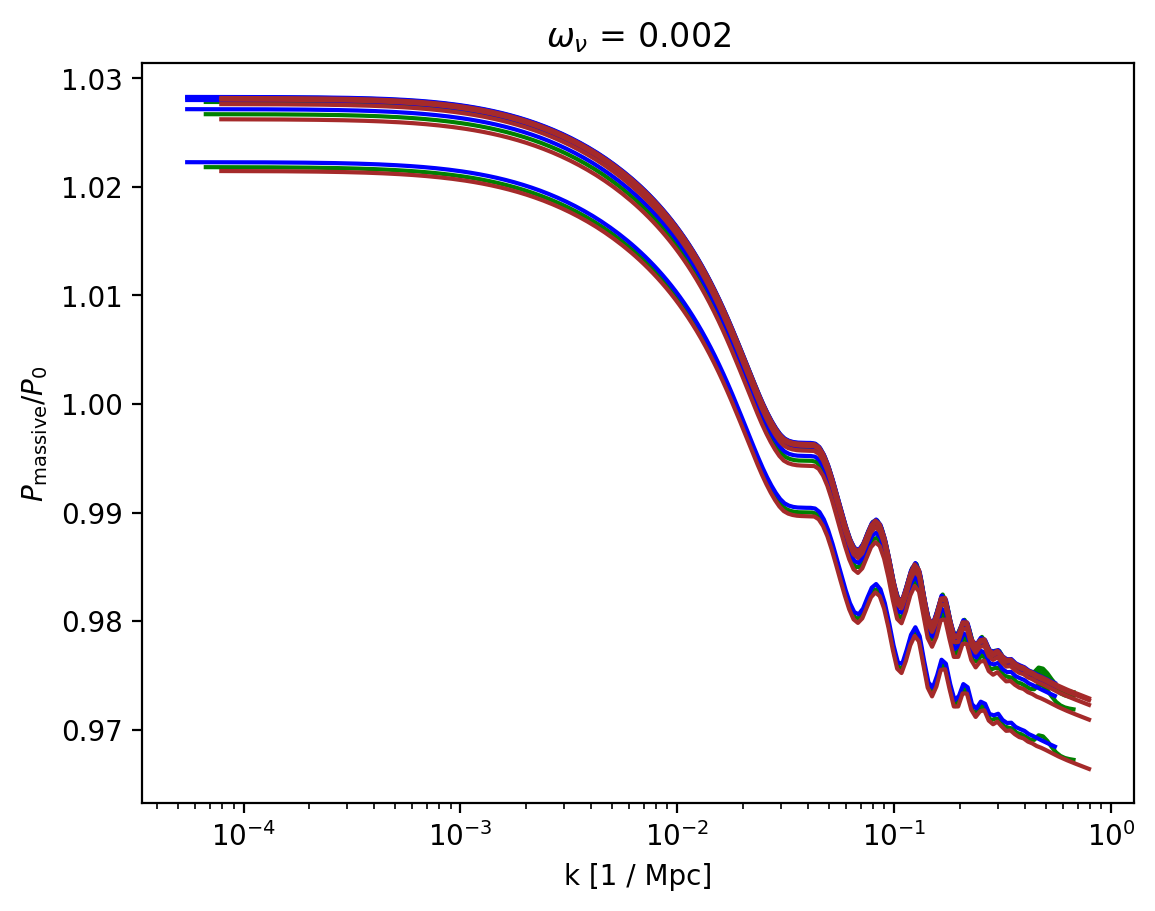

In [6]:
for i in range(0, 3):
    h = models.cosm[i]["H0"] / 100
    for j in range(5):
        plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i) + \
                 ", no renormalizing, z=" + str(redshifts[j]),
                c=colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(models.omega_nu[1]))
    #plt.legend()

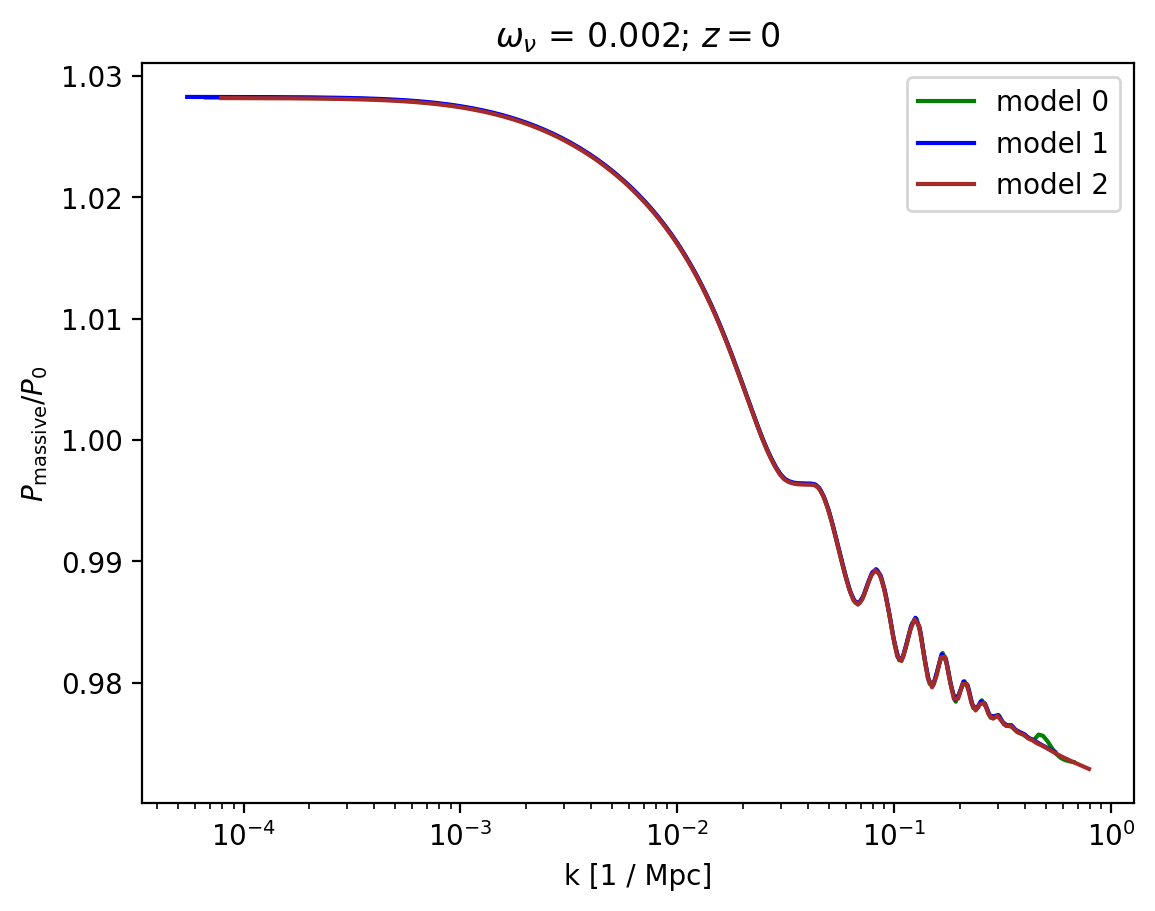

In [11]:
for i in range(0, 3):
    h = models.cosm[i]["H0"] / 100
    j = 4 # just look at z=0 before moving on
    plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i), c=colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(models.omega_nu[1]) + "; $z=0$")
    plt.legend()

Problems? and problems:
* I am currently not re-normalizing the amplitude of one model mased on its counterpart. At least, I *think* I'm not doing that.
* I need to set a k_min value so that the x axes align better